# **Instacart Customer Segmentation & Market Basket Analysis**

##**Overview** 

Instacart is an America based company that provides same day grocery service in United States and Canada.Instacart was founded a decade ago in 2012 in San Fransisco Bay Area to deliver grocery online to customers from local grocers. By 2017, Instacart was operating nationwide in US while also expanding across Canada (Instacart, 2022).

Instacart operates on crowdsourced marketplace model in which a user/consumer places an order from desired store and a shopper near that store shops, packs and delivers the products within the designated time frame (Juggernaut,2015).

Over last several years e-commerce industry has experienced exponential growth rate which was further accelerated by covid-19 pandemic and lockdowns. According to the 'State of Grocery Report 2021' of 1010Data, ecommerce spending increased 66% year over year in 2020 while online grocery spending saw year over growth rate of 133% in 2020. While the YOY growth rate of overall online grocery sales was 8% in 2021, Instacart's sales grew at 14% (Redman, 2022).  Pandemic played huge role in changing trend of grocery purchase, when people started shoping online for groceries. Instacart drove this adoption of online groceries with significant growth in users; 46% of Instacart users were new in 2020 (1010Data, 2021).

##**Business** **Objective**

E-commerce businesses like Instacart are focus on Expanding customer base, 
retaining existing customers and increasing profitability per order. A huge chunk of company's expense goes towards marketing and advertisements. Primary objective of Instacart is to be able to identify the basket that might be bought again by the users so to customize the push notifications such as e-mail or in-app for each customer and prepare a custom basket of most reordered products of the users. This will help a) save customer's time, thereby improving the value of service and customer retention b) developing personalized push notification will trigger purchases.

The aim of this project is to:
* Segment customers : Clustering customers based on their past purchase behviour
* Customer target : Identify the targeting customer
* Product recommendation : Determining the products that will be reordered by the customers for personlized product recommendation

**Entity Relationship Diagram**

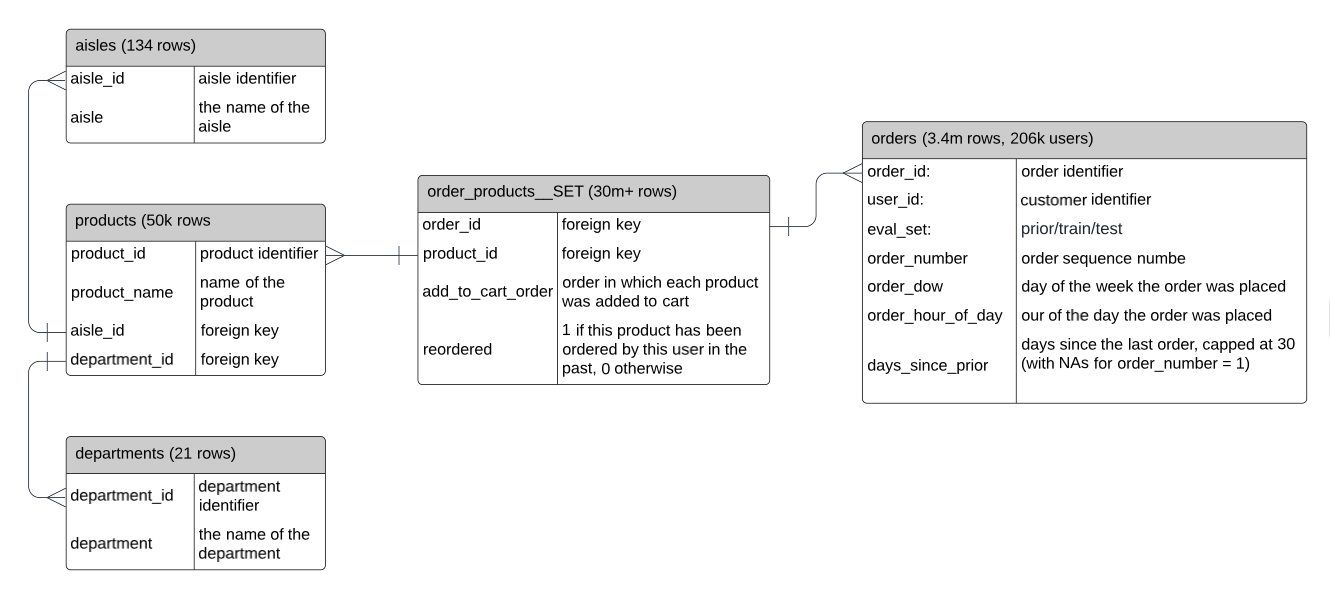

**Data description:** 

orders (3.4m rows, 206k users):
* order_id: order identifier
* user_id: customer identifier
* eval_set: which evaluation set this order belongs in (see SET described below)
* order_number: the order sequence number for this user (1 = first, n = nth)
* order_dow: the day of the week the order was placed on
* order_hour_of_day: the hour of the day the order was placed on
* days_since_prior: days since the last order, capped at 30 (with NAs for order_number = 1)

products (50k rows):
* product_id: product identifier
* product_name: name of the product
* aisle_id: foreign key
* department_id: foreign key

aisles (134 rows):
* aisle_id: aisle identifier
* aisle: the name of the aisle

departments (21 rows):
* department_id: department identifier
* department: the name of the department

order_products__SET (30m+ rows):
* order_id: foreign key
* product_id: foreign key
* add_to_cart_order: order in which each product was added to cart
* reordered: 1 if this product has been ordered by this user in the past, 0 otherwise

where SET is one of the four following evaluation sets (eval_set in orders):
* "prior": orders prior to that users most recent order (~3.2m orders)
* "train": training data supplied to participants (~131k orders)
* "test": test data reserved for machine learning competitions (~75k orders)

### **Downloading the Dataset**

We can directly download the dataset from Kaggle within the notebook using the `opendatasets` library.

In [ ]:
!pip install opendatasets --quiet 
!pip install matplotlib --quiet
!pip install squarify

import opendatasets as od
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
import pandas as pd
import numpy as np
import matplotlib
import os

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

Need to provide Kaggle credentials to download the data. 
Follow these [instructions](http://bit.ly/kaggle-creds) .

In [ ]:
od.download('https://www.kaggle.com/competitions/instacart-market-basket-analysis')

In [4]:
#Checking the list of dataset in the directory
os.listdir('instacart-market-basket-analysis')

['products.csv.zip',
 'aisles.csv.zip',
 'sample_submission.csv.zip',
 'order_products__prior.csv.zip',
 'departments.csv.zip',
 'order_products__train.csv.zip',
 'orders.csv.zip']

The dataset is downloaded and now let's unzip and extract the files to the folder `'market-basket'`.

In [5]:
from zipfile import ZipFile

with ZipFile('instacart-market-basket-analysis/aisles.csv.zip') as f:
    f.extractall(path='market-basket')
with ZipFile('instacart-market-basket-analysis/orders.csv.zip') as f:
    f.extractall(path='market-basket')
with ZipFile('instacart-market-basket-analysis/departments.csv.zip') as f:
    f.extractall(path='market-basket')  
with ZipFile('instacart-market-basket-analysis/order_products__prior.csv.zip') as f:
    f.extractall(path='market-basket')
with ZipFile('instacart-market-basket-analysis/order_products__train.csv.zip') as f:
    f.extractall(path='market-basket')
with ZipFile('instacart-market-basket-analysis/products.csv.zip') as f:
    f.extractall(path='market-basket')
os.listdir('market-basket')

['departments.csv',
 'aisles.csv',
 'order_products__train.csv',
 'orders.csv',
 'order_products__prior.csv',
 '__MACOSX',
 'products.csv']

Reading datasets into pandas dataframe.

In [6]:
aisle = pd.read_csv('./market-basket/aisles.csv')
dept = pd.read_csv('./market-basket/departments.csv')
products = pd.read_csv('./market-basket/products.csv')
order_train = pd.read_csv('./market-basket/order_products__train.csv', low_memory=False)
orders = pd.read_csv('./market-basket/orders.csv', low_memory=False)
order_prior = pd.read_csv('./market-basket/order_products__prior.csv', low_memory=False )

###**Data Preparation**

We have large dataset with records in millions. So I will use a function written by [Guillaume Martin](https://www.kaggle.com/code/gemartin/load-data-reduce-memory-usage/notebook) to reduce the memory usage in pandas. The following function optimizes the memory usage by effective use of datatype. Firstly, it returns the memory usage of each column in MB and then iterates through each column and modify the datatype. The smallest integer in NumPy is int8 which needs only 1 byte and can store values between -128 and 127. So it makes sense in our case to use the smallest integer type and reduce the memory usage significantly.

In [7]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

In [8]:
reduce_mem_usage(orders)
reduce_mem_usage(order_prior)
reduce_mem_usage(order_train)

Memory usage of dataframe is 182.71 MB
Memory usage after optimization is: 45.68 MB
Decreased by 75.0%
Memory usage of dataframe is 989.82 MB
Memory usage after optimization is: 340.25 MB
Decreased by 65.6%
Memory usage of dataframe is 42.26 MB
Memory usage after optimization is: 13.20 MB
Decreased by 68.7%


The function has decreased the memory usage by atleast 65%. Now, lets look at the sample of each dataframe to get familiar with datasets.

In [ ]:
print(aisle.shape)
aisle.head()

(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [ ]:
print(dept.shape)
dept.head()

(21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [ ]:
print(products.shape)
products.head()

(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
print(orders.shape)
orders.head()

(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [ ]:
print(order_train.shape)
order_train.head()

(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [ ]:
print(order_prior.shape)
order_prior.head()

(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


Let's look for the null values in datasets.

In [ ]:
print(aisle.isna().sum())
print(dept.isna().sum())
print(products.isna().sum())
print(order_prior.isna().sum())
print(order_train.isna().sum())
print(orders.isna().sum())

aisle_id    0
aisle       0
dtype: int64
department_id    0
department       0
dtype: int64
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64
order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64


As stated earlier in the data description, `day_since_prior_order` is null for user's first order. We have 206,209 users in the dataset and 206,209 first time orders.

Now, lets also check for duplicate rows.

In [ ]:
print(aisle.duplicated().any())
print(dept.duplicated().any())
print(products.duplicated().any())
print(orders.duplicated().any())
print(order_prior.duplicated().any())
print(order_train.duplicated().any())

False
False
False
False
False
False


In [ ]:
aisle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [ ]:
dept.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   user_id                 int32   
 2   eval_set                category
 3   order_number            int8    
 4   order_dow               int8    
 5   order_hour_of_day       int8    
 6   days_since_prior_order  float16 
dtypes: category(1), float16(1), int32(2), int8(3)
memory usage: 45.7 MB


In [ ]:
order_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int32
 1   product_id         int32
 2   add_to_cart_order  int16
 3   reordered          int8 
dtypes: int16(1), int32(2), int8(1)
memory usage: 340.3 MB


In [ ]:
order_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int32
 1   product_id         1384617 non-null  int32
 2   add_to_cart_order  1384617 non-null  int8 
 3   reordered          1384617 non-null  int8 
dtypes: int32(2), int8(2)
memory usage: 13.2 MB


In `orders` dataframe, let's convert `order_dow` into more interpretable form.

In [9]:
def weekday(dow):
  if dow == 0:
    return 'Saturday'
  elif dow ==  1:
    return 'Sunday'
  elif dow == 2:
    return 'Monday'
  elif dow == 3:
    return 'Tuesday'
  elif dow == 4:
    return 'Wednesday'
  elif dow == 5:
    return 'Thursday'
  else:
     return 'Friday'

orders['order_dow'] = orders['order_dow'].apply(weekday)

Similary, I will convert `hour_of_the_day` into part_of_the_day.

In [10]:
def part_of_day(hour):
    if hour >= 6 and hour < 10:
        return "Morning"
    elif hour >= 10 and hour < 12:
        return "Day"
    elif hour >= 12 and hour < 14:
        return "Lunch"
    elif hour >= 14 and hour < 17:
        return "Afternoon"
    elif hour >= 17 and hour < 20:
        return "Evening"
    else:
        return "Night"

orders['part_of_day'] = orders['order_hour_of_day'].map(part_of_day)

In [ ]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,part_of_day
0,2539329,1,prior,1,Monday,8,NaN,Morning
1,2398795,1,prior,2,Tuesday,7,15.0,Morning
2,473747,1,prior,3,Tuesday,12,21.0,Lunch
3,2254736,1,prior,4,Wednesday,7,29.0,Morning
4,431534,1,prior,5,Wednesday,15,28.0,Afternoon


### **Exploratory Analysis & Visualisation** 

In [ ]:
print('Total number of users in the dataset is', orders.user_id.nunique())

Total number of users in the dataset is 206209


In [ ]:
print('Dataset is divided into \n', orders.eval_set.value_counts())

Dataset is divided into 
 prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64


In [11]:
#setting up color palette for graphs

color_codes = ["#ff8200", "#43b02a", "#0e4f28"]
color_name = ['orange', 'green', 'kale_green']

c = lambda x: color_codes[color_name.index(x)]

**Order Analysis**

Maximum number of orders by a user is 100
Minimum number of orders by a user is 4
Average number of orders by a user is 17


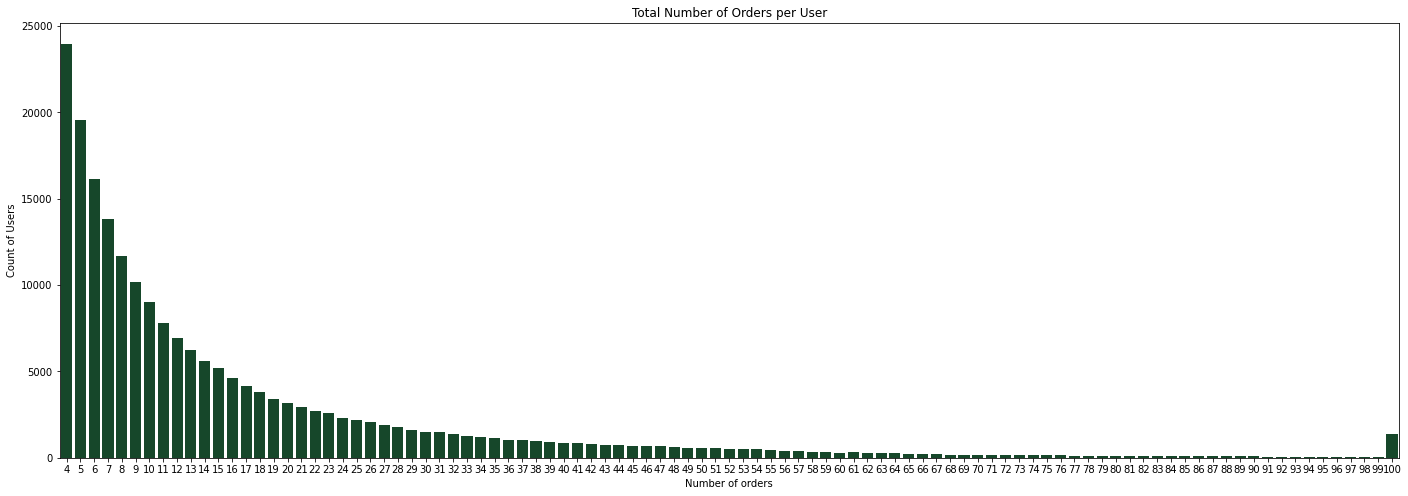

In [ ]:
order_per_user = orders.groupby('user_id')['order_id'].count().reset_index().sort_values(by = 'order_id', ascending= False)
order_per_user = order_per_user.groupby('order_id')['user_id'].count().reset_index().sort_values(by = 'order_id', ascending= False)

print(f'Maximum number of orders by a user is {order_per_user.order_id.max()}')
print(f'Minimum number of orders by a user is {order_per_user.order_id.min()}')
print('Average number of orders by a user is', round(orders.groupby('user_id')['order_id'].count().mean()))

plt.figure(figsize=(24,8))
sns.barplot('order_id', 'user_id', data = order_per_user,color= c('kale_green'))
plt.title('Total Number of Orders per User')
plt.xlabel('Number of orders')
plt.ylabel('Count of Users');

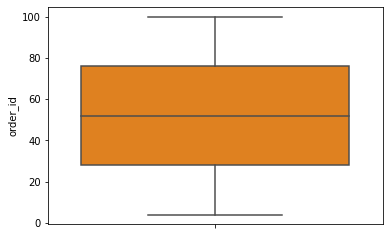

In [ ]:
sns.boxplot(y = order_per_user['order_id'], color = c('orange'));

* While every user has ordered atleast 4 times from Instacart, some of the 
users have ordered 100 times.
* Most users have between 4 and 10 number of orders.
* On an average, users order 17 times from Instacart.

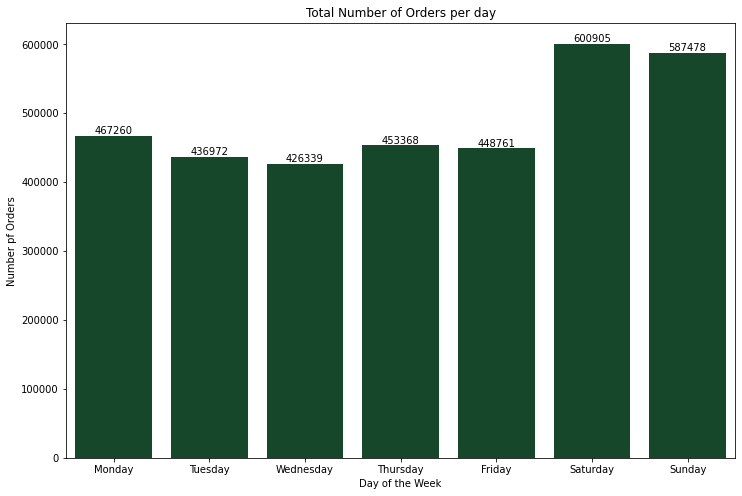

In [ ]:
week = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekly_order = orders.groupby('order_dow')['order_id'].count().reindex(week).reset_index()

plt.figure(figsize=(12,8))
ax = sns.barplot('order_dow', 'order_id', data = weekly_order,color= c('kale_green'))
ax.bar_label(ax.containers[0])
plt.title('Total Number of Orders per day')
plt.xlabel('Day of the Week')
plt.ylabel('Number pf Orders');

Maximum number of orders are placed during weekend, when people prepare for the week ahead. 

Now let's look at the most busy hour for the website.

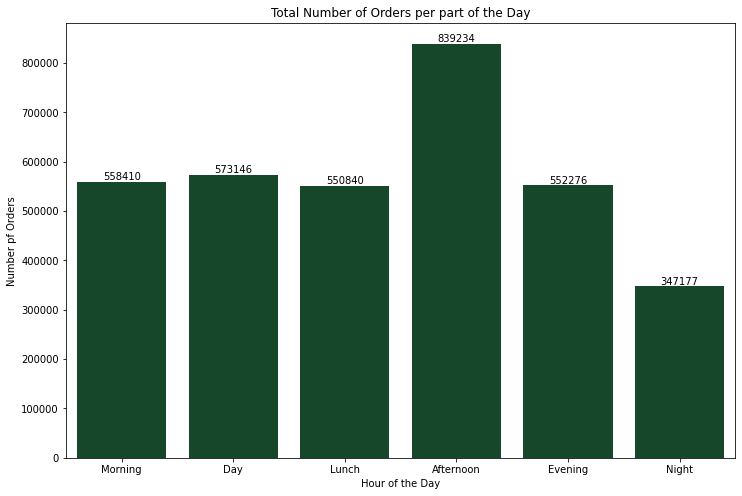

In [ ]:
hour = ['Morning', 'Day', 'Lunch','Afternoon', 'Evening', 'Night']

hourly_order = orders.groupby('part_of_day')['order_id'].count().reindex(hour).reset_index()

plt.figure(figsize=(12,8))
ax = sns.barplot('part_of_day', 'order_id', data = hourly_order,color= c('kale_green'))
ax.bar_label(ax.containers[0])
plt.title('Total Number of Orders per part of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number pf Orders');

Most people like to shop between 2pm and 5 pm. Now, let's combine days and hour together to determine the pattern.

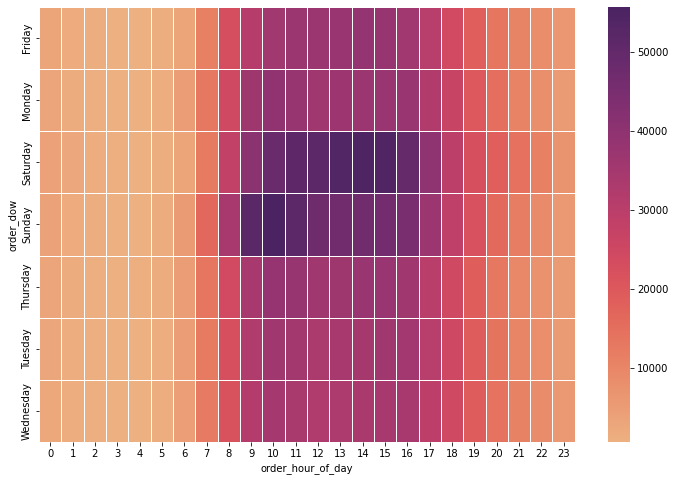

In [ ]:
hour_day = orders.groupby(["order_dow", "order_hour_of_day"])["order_id"].count().reset_index()
hour_day = hour_day.pivot(index = 'order_dow', columns = 'order_hour_of_day', values = 'order_id')

plt.figure(figsize=(12,8))
sns.heatmap(hour_day, cmap = 'flare',linewidths=.8);

Busiest time of the day seems to be Saturday afternoon and Sunday morning.

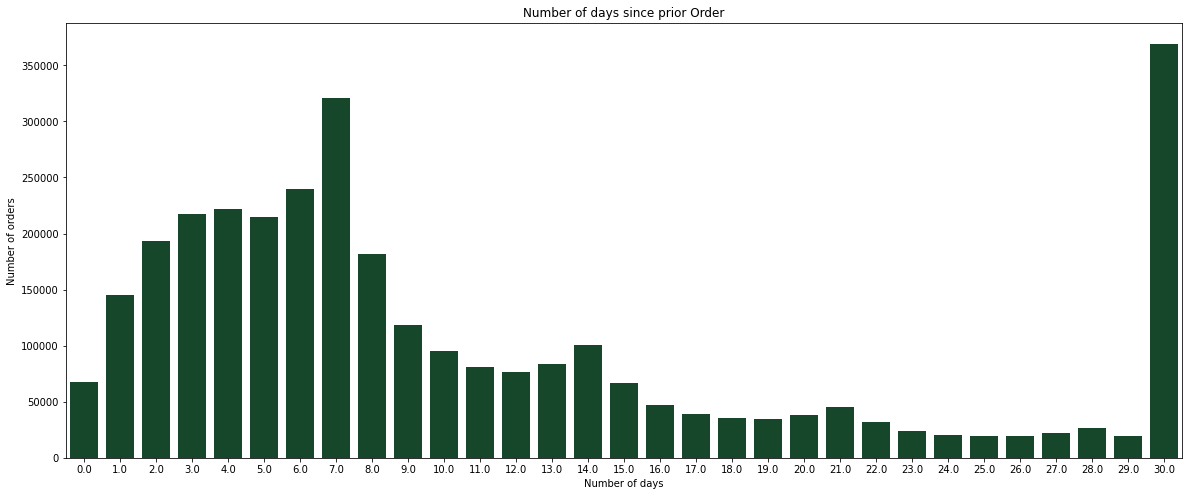

In [ ]:
days_since_last_order = orders.groupby('days_since_prior_order')['order_id'].count().reset_index()

plt.figure(figsize=(20,8))
sns.barplot('days_since_prior_order', 'order_id', data = days_since_last_order,color= c('kale_green'))
plt.title('Number of days since prior Order')
plt.xlabel('Number of days')
plt.ylabel('Number of orders');

Most number of orders are placed after 30 days followed by 7 days and another jump at 14 days. Hence, we can determine that users usually shops monthly, weekly and biweekly.

> Please note that number of `days_since_prior_order` is capped at 30 days. 


Let's merge `order_prior` with products, department and aisle data for further detailed analysis.

In [12]:
#merging order_prior with products, department and aisle dataset
merged_orders = order_prior.merge(products, on = 'product_id', how = 'left').merge(dept, on = 'department_id', how = 'left').merge(aisle, on = 'aisle_id', how = 'left')

merged_orders.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,Natural Sweetener,17,13,pantry,baking ingredients


In [13]:
#reordering the column order and removing department_id and aisle_id columns

merged_orders = merged_orders[['order_id', 'product_id', 'product_name', 'reordered','department','aisle', 'add_to_cart_order']]
merged_orders.head()

,order_id,product_id,product_name,reordered,department,aisle,add_to_cart_order
0,2,33120,Organic Egg Whites,1,dairy eggs,eggs,1
1,2,28985,Michigan Organic Kale,1,produce,fresh vegetables,2
2,2,9327,Garlic Powder,0,pantry,spices seasonings,3
3,2,45918,Coconut Butter,1,pantry,oils vinegars,4
4,2,30035,Natural Sweetener,0,pantry,baking ingredients,5


**Product Analysis**

Maximum number of products in an order is 145
Minimum number of products in an order is 1


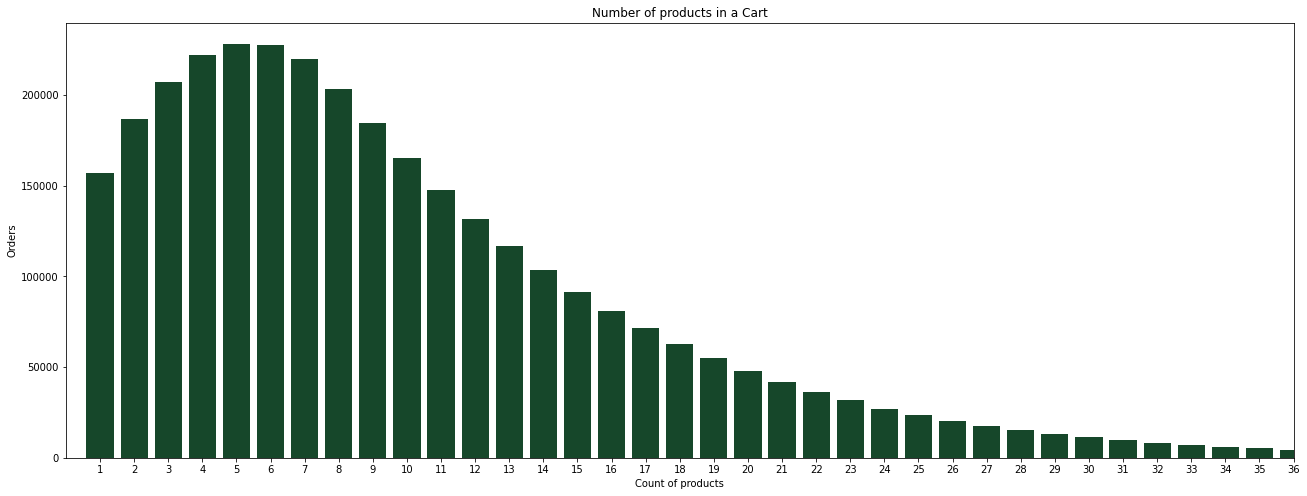

In [ ]:
products_per_order = merged_orders.groupby('order_id')['product_id'].count().reset_index().sort_values(by='product_id', ascending = False)
products_per_order = products_per_order.groupby('product_id')['order_id'].count().reset_index()

print('Maximum number of products in an order is', products_per_order['product_id'].max())
print('Minimum number of products in an order is', products_per_order['product_id'].min())

plt.figure(figsize=(22,8))
sns.barplot('product_id', 'order_id', data = products_per_order,color= c('kale_green'))
plt.xlim(-1,35)
plt.title('Number of products in a Cart')
plt.xlabel('Count of products')
plt.ylabel('Orders');

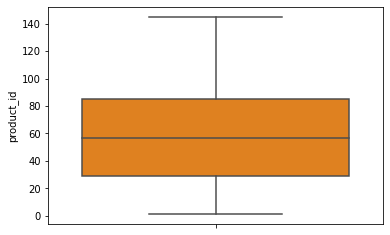

In [ ]:
sns.boxplot(y = products_per_order['product_id'], color = c('orange'));

Most users buy 1-10 number of products in an order. Few users buy more than 30 products per order and a minor segment of users buy more 50 products. Highest number of product in an order is 145.

In [ ]:
def popularity(column_name):
  
  ''' Creating a dataframe based on a column to determine its popularity and plotting a bar graph'''

  x = merged_orders.groupby(column_name)['order_id'].count().reset_index().sort_values(by='order_id', ascending = False)

  plt.figure(figsize=(22,8))
  ax = sns.barplot(column_name, 'order_id', data = x,color= c('kale_green'))
  plt.xlim(-1,15)
  plt.xticks(rotation=70)
  plt.xlabel(column_name)
  plt.ylabel('Count of Orders')

  return ax

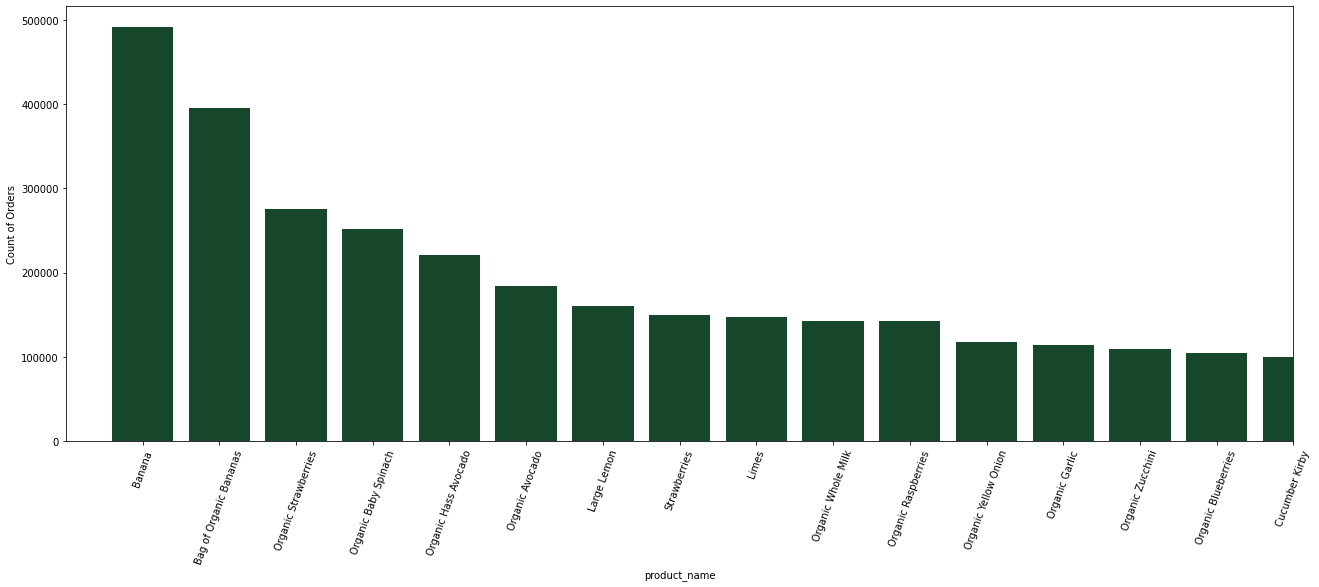

In [ ]:
popularity('product_name');

Fruit & vegetables are the most bought products by users. Interestingly, 11 out of 15 products are organic. People seem to prefer organic produce over normal produce. We can further explore `organic' section, determine people's preference for organic products. 

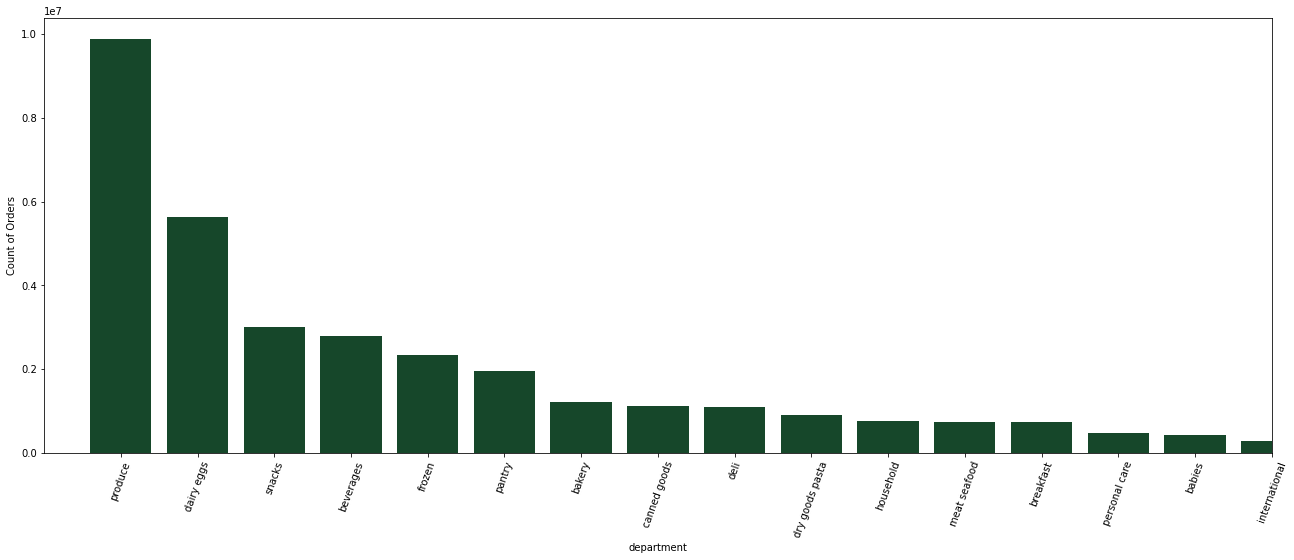

In [ ]:
popularity('department');

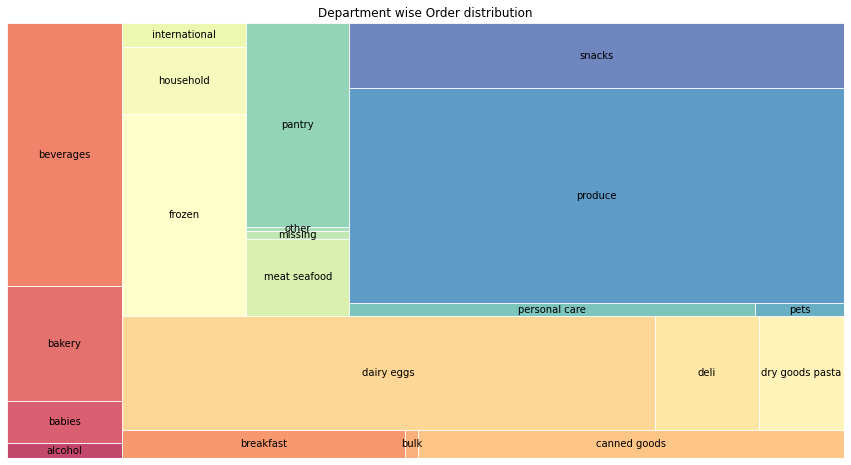

In [31]:
departments = merged_orders.groupby('department')['order_id'].count().reset_index()

size = departments['order_id'].values
label = departments['department']

#plotting a treemap 
plt.figure(figsize=(15,8))
squarify.plot(sizes = size, label = label,alpha=.8, edgecolor="white", linewidth=1,  color = sns.color_palette("Spectral", len(size)))
plt.axis('off')
plt.title('Department wise Order distribution');

Most ordered products are from fresh produce, dairy eggs, snacks, beverages & frozen department. Result is expected as these grocery items are perishable and consumed quickly.

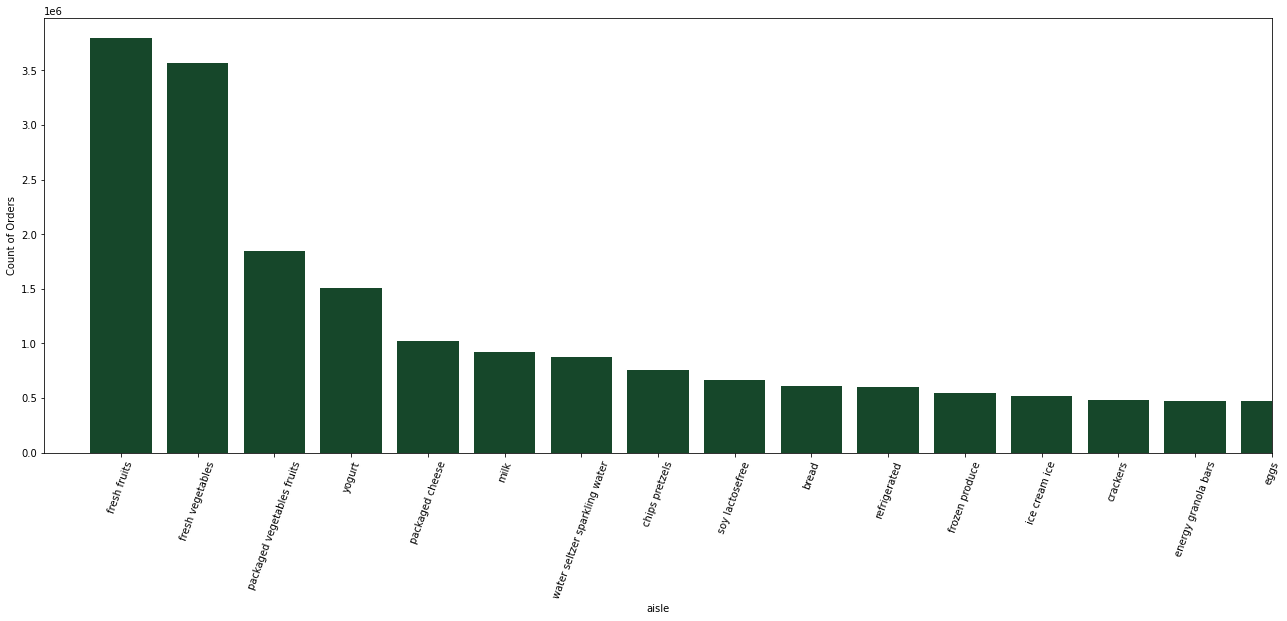

In [ ]:
popularity('aisle');

Interestingly, people consume more cheese than milk.

Lets look at the list of 3 Best Selling Aisles in each Department.

In [ ]:
best_selling_aisles = merged_orders.groupby(["department", "aisle"])["order_id"].aggregate('count').reset_index()

#Top 3 aisles in each department
best_selling_aisles.groupby(["department"]).apply(lambda x: x.sort_values(["order_id"], ascending = False).head(3)).reset_index(drop=True)

,department,aisle,order_id
0,alcohol,beers coolers,48657
1,alcohol,red wines,35181
2,alcohol,white wines,30558
3,babies,baby food formula,382456
4,babies,diapers wipes,24605
5,babies,baby bath body care,8581
6,bakery,bread,584834
7,bakery,breakfast bakery,250770
8,bakery,tortillas flat bread,193297
9,beverages,water seltzer sparkling water,841533



In later stage, we can also analyse the popularity of departments according to the day & hour.

**Reorder Pattern**

In [ ]:
print('Reorder ratio is ',round(merged_orders.reordered.mean(),2))

Reorder ratio is  0.59


In [ ]:
def reorder_ratio(column_name):
  
  ''' Creating a dataframe based on an column to determine its reorder ratio and plotting a point plot graph'''

  x = merged_orders.groupby(column_name)['reordered'].mean().reset_index().sort_values(by='reordered', ascending = False)

  plt.figure(figsize=(22,8))
  ax = sns.pointplot(column_name, 'reordered', data = x,color= c('kale_green'))
  plt.xlim(-1,21)
  plt.xticks(rotation=70)
  plt.xlabel(column_name)
  plt.ylabel('Reorder Ratio')

  return ax

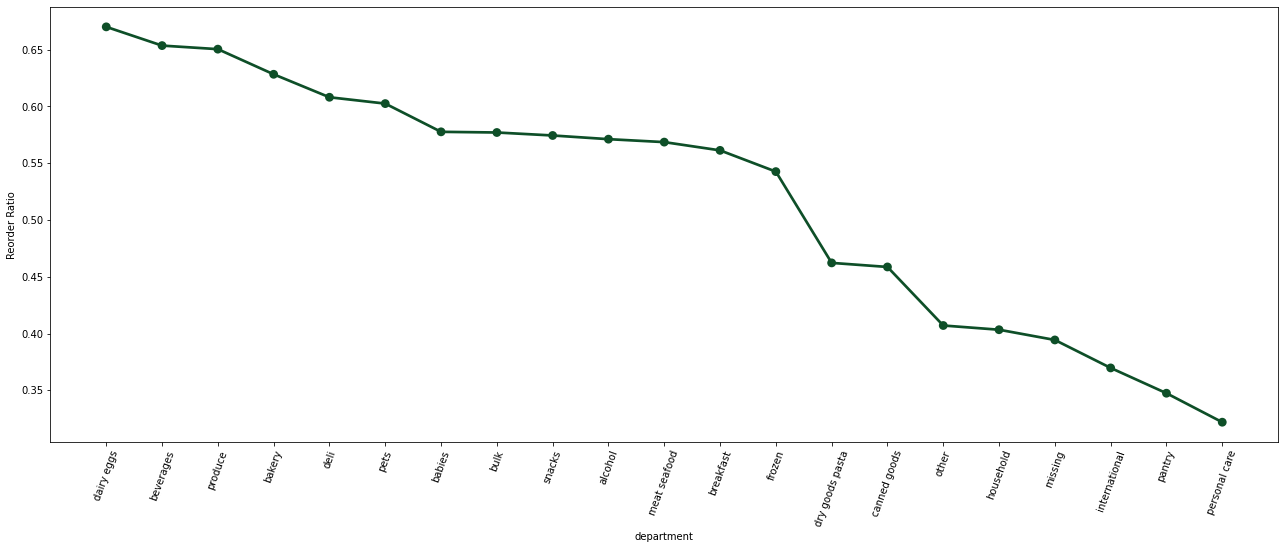

In [ ]:
reorder_ratio('department');

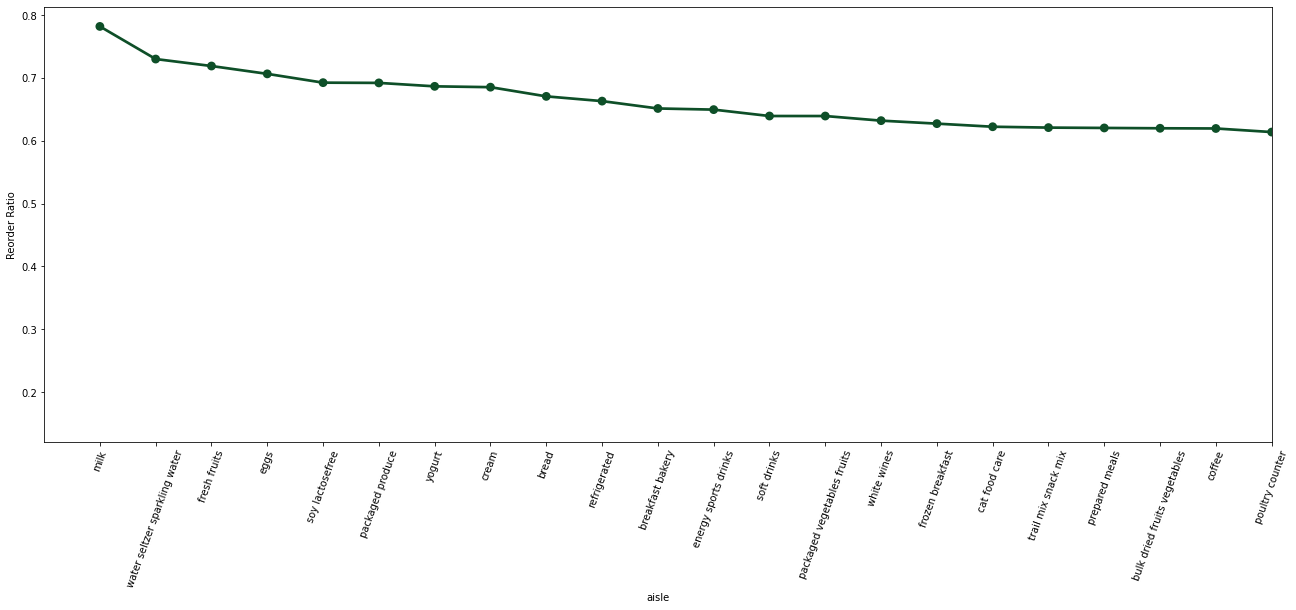

In [ ]:
reorder_ratio('aisle');

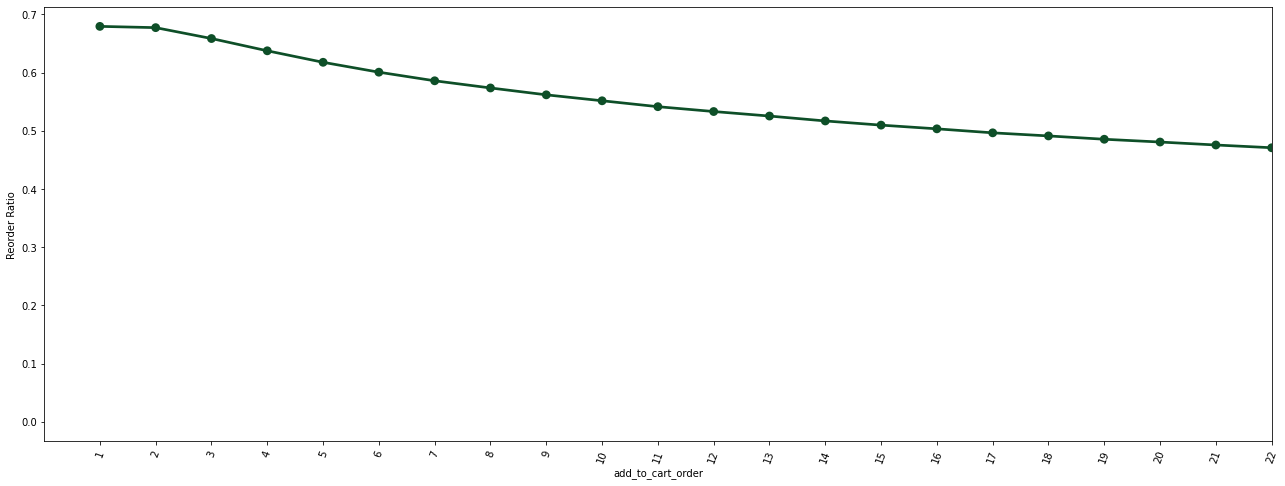

In [ ]:
reorder_ratio('add_to_cart_order');

A user usually adds frequently reordered products at the beginning of the cart. Hence,products added in beginning of the order are most reordered products.

Let's merge `merged` dataset with `orders` data for further analysis.

In [32]:
#full dataset
dataset = merged_orders.merge(orders, on = 'order_id', how = 'left')

In [33]:
#reordering column sequence
dataset = dataset[['order_id', 'user_id', 'order_number' ,'product_name', 'reordered', 'order_dow', 'order_hour_of_day','part_of_day',
                  'department', 'aisle', 'add_to_cart_order', 'days_since_prior_order', 'eval_set']]

dataset.head()

,order_id,user_id,order_number,product_name,reordered,order_dow,order_hour_of_day,part_of_day,department,aisle,add_to_cart_order,days_since_prior_order,eval_set
0,2,202279,3,Organic Egg Whites,1,Thursday,9,Morning,dairy eggs,eggs,1,8.0,prior
1,2,202279,3,Michigan Organic Kale,1,Thursday,9,Morning,produce,fresh vegetables,2,8.0,prior
2,2,202279,3,Garlic Powder,0,Thursday,9,Morning,pantry,spices seasonings,3,8.0,prior
3,2,202279,3,Coconut Butter,1,Thursday,9,Morning,pantry,oils vinegars,4,8.0,prior
4,2,202279,3,Natural Sweetener,0,Thursday,9,Morning,pantry,baking ingredients,5,8.0,prior


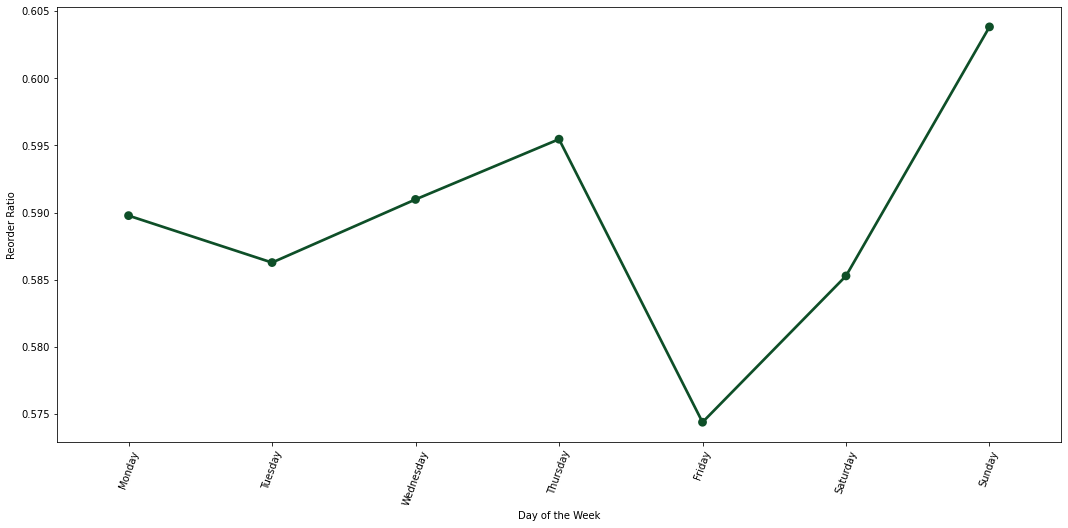

In [ ]:
week = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

reorder_dow = dataset.groupby('order_dow')['reordered'].mean().reindex(week).reset_index()

plt.figure(figsize=(18,8))
ax = sns.pointplot('order_dow', 'reordered', data = reorder_dow,color= c('kale_green'))
plt.xticks(rotation=70)
plt.xlabel('Day of the Week')
plt.ylabel('Reorder Ratio');

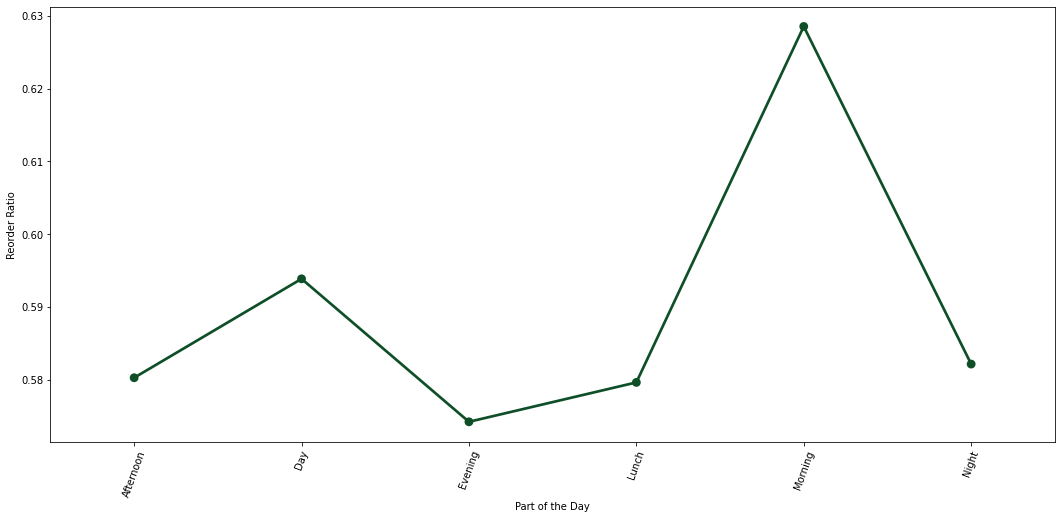

In [ ]:
reorder_hour = dataset.groupby('part_of_day')['reordered'].mean().reset_index()

plt.figure(figsize=(18,8))
ax = sns.pointplot('part_of_day', 'reordered', data = reorder_hour,color= c('kale_green'))
plt.xticks(rotation=70)
plt.xlabel('Part of the Day')
plt.ylabel('Reorder Ratio');

Most reordered products are ordered on Sundays and during mornings.

In [ ]:
#Average reorder ratio between user's second order and tenth order

for x in range(2,11):
  print(round(dataset[dataset['order_number'] == x]['reordered'].mean(),3))

0.272
0.386
0.458
0.507
0.545
0.576
0.599
0.62
0.637


So, as the number of orders increases, people tend to reorder previously bought products.

In [ ]:
reordered_prod = dataset[dataset['order_number'] != 1].groupby(['order_id'])['reordered'].mean().round(2).reset_index()

print('Percentage of non-first order with no reordered product is ', round((reordered_prod[reordered_prod['reordered'] == 0.00]['order_id'].count())/reordered_prod['order_id'].count(),2))
print('Percentage of non-first order with all reordered product is', round((reordered_prod[reordered_prod['reordered'] == 1]['order_id'].count())/reordered_prod['order_id'].count(),2))

Percentage of non-first order with no reordered product is  0.06
Percentage of non-first order with all reordered product is 0.23


So, 6% of the non-first orders do not contain any reordered product while 23% of orders have all the reordered products.


In [ ]:
all_reordered = reordered_prod[reordered_prod['reordered'] == 1]
reorder = dataset[dataset['order_id'].isin(all_reordered['order_id'])]

print('Day of the week:',reorder['order_dow'].mode())
print('Part of the day: ' ,reorder['part_of_day'].mode())
print('Department:', reorder['department'].mode())
print('Aisle: ', reorder['aisle'].mode())

Day of the week: 0    Sunday
dtype: object
Part of the day:  0    Afternoon
dtype: object
Department: 0    produce
dtype: object
Aisle:  0    fresh fruits
dtype: object


As expected, fresh produce is the most repordered products. On sunday afternoon people restock their refrigerators for the week.

Let's look at the how department wise orders differ on the basis of days and hours. For example, fresh produce is expected to be ordered on weekend afternoon based on our data analysis. Whereas, people are more likely to order alchol at the beginning of the weekend i.e. on fridays or thursdays.

In [ ]:
def dept_name(x):
  
  ''' Create a subset of department data, groups by order_dow & hour_of_day and 
  then visualises a heatmap to reflect the density of orders based on days and hour '''

  order_dpt = dataset[dataset['department']== x]
  group = order_dpt.groupby(['order_dow', 'order_hour_of_day']).agg('count').reset_index()
  heatmap = group.pivot('order_dow', 'order_hour_of_day', 'order_id')
  
  sns.heatmap(data=heatmap, cmap="flare", linewidths=.8)
  plt.title('Frequency of products ordered for '+x+' in per each day and hour')
  plt.ylabel('Day of week')
  plt.xlabel('Hour of day')
  plt.show()

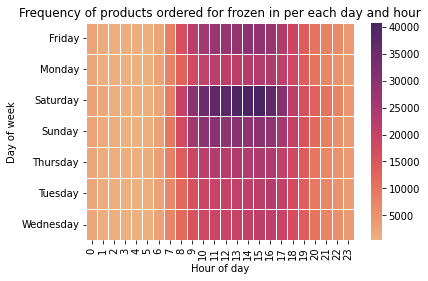

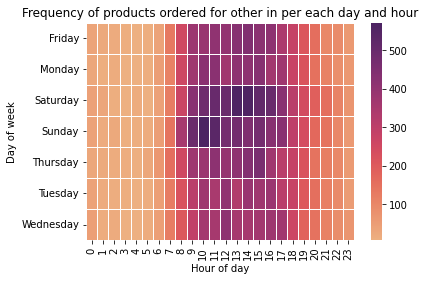

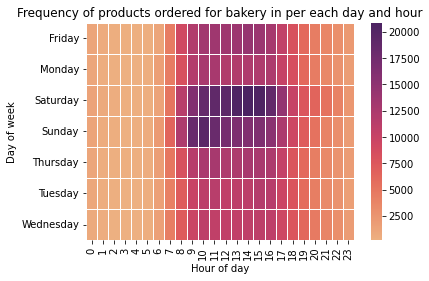

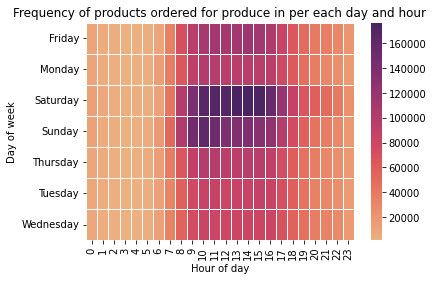

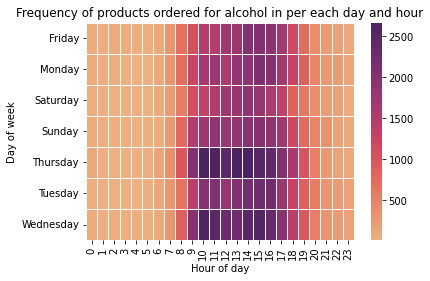

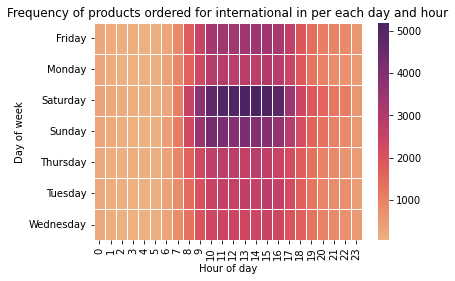

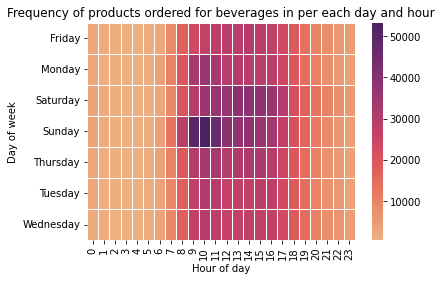

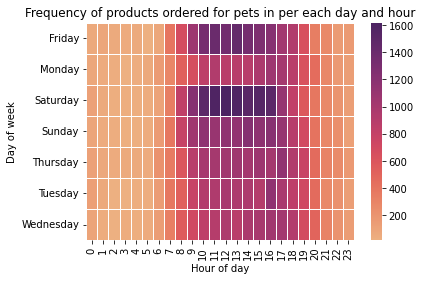

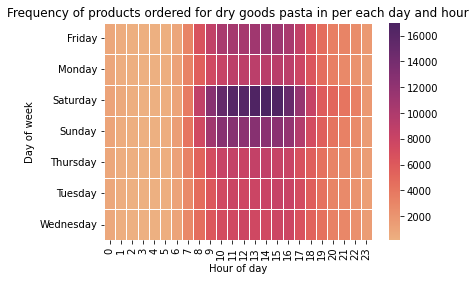

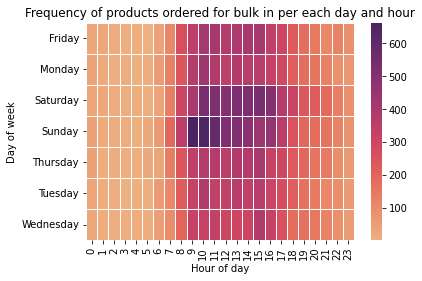

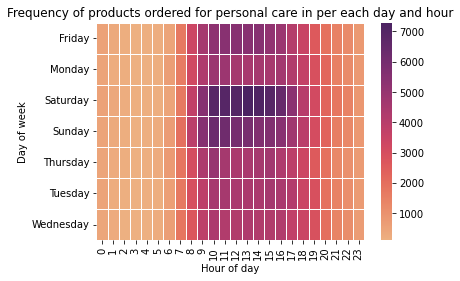

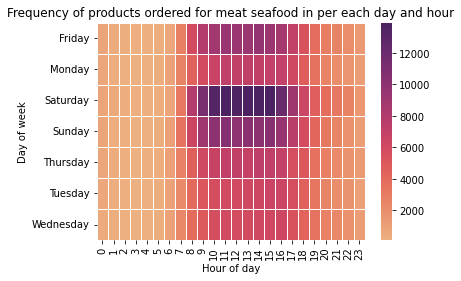

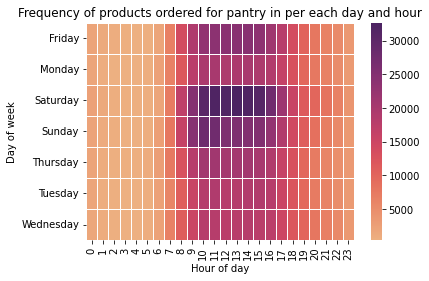

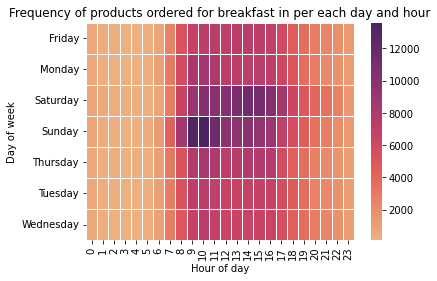

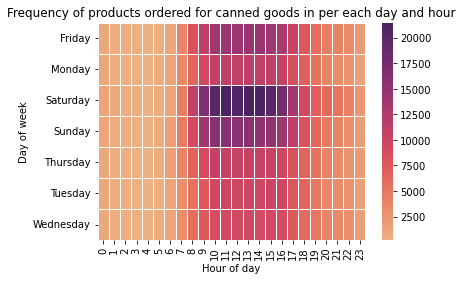

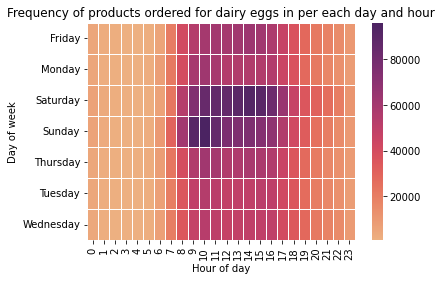

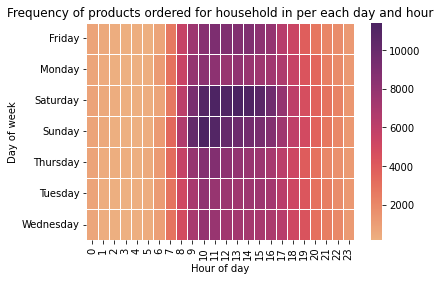

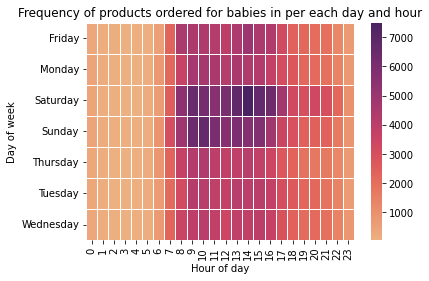

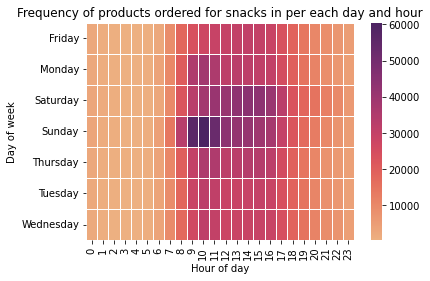

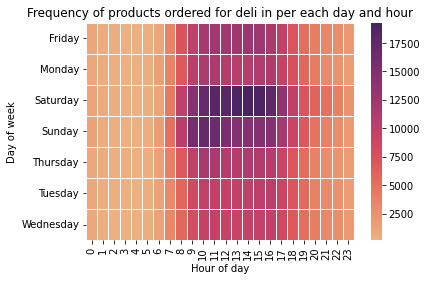

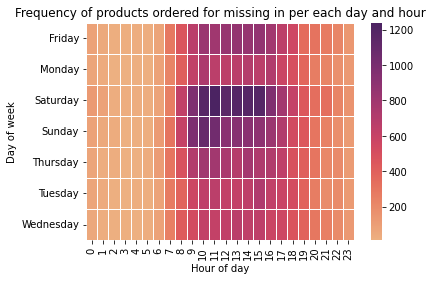

In [ ]:
for x in dept['department']:
  dept_name(x)

While, most products are ordered during weekends, alcohol is usually ordered during weekdays(Tuesday, wednesday & Thursday).

At the end, Lets look at the organic products.

In [ ]:
print('Count of Organic products:', products[products['product_name'].str.contains('Organic')]['product_id'].count())
print('Percentage of Organic products:', (100 * products[products['product_name'].str.contains('Organic')]['product_id'].count())/products['product_id'].count())

Count of Organic products: 5035
Percentage of Organic products: 10.133231363709548


In [ ]:
print('Percentage of orders that contains Organic products:',(100 * dataset[dataset['product_name'].str.contains('Organic')]['order_id'].count())/dataset['order_id'].count())

Percentage of orders that contains Organic products: 31.603371337220697


In [ ]:
print('Reorder ratio of organic products is : ',dataset[dataset['product_name'].str.contains('Organic')]['reordered'].mean())

Reorder ratio of organic products is :  0.6349255716269192


On the basis of the above analysis, it seems that people are more inclined towards organics produce. Around 31% of the orders contain organic products and the reorder ratio is also quite high for organic products.

## **Summary**

Based on the above analysis, we can conclude that:
 
 

*   A regular Instacart user will have on an average 17 orders.
*   Users usually order on weekends, during mornings and noon. People shop for grocery during weekends and prepare for the week ahead. 
*   Users usually buy alcohol in the middle of the week.
*   Users buy grocery on weekly, biweekly and monthly basis.
*   Users usually buy between 1 to 10 products in a single order.
*   As expected fresh fruits & vegetables are most ordered products, followed by yogurt, cheese and milk.
*   Departments like produce, baby, deli, alcohol, pets, bakery have reorder ratio of more than .50, while long shelf like products like pantry and personal care have reorder ratio of less than .30.
*  Products added in the beginning of the cart are the products which a user usually buys.
* 23% of orders have all the reordered products, which shows that some of users buy same set of products multiple times. So, these customers will be benefitted from the auto-fill options.
* We can also see people inclination towards organic products. Out of top 15 products, 11 products are organic. So while 10% of the products are organic, around 30% of the orders contaion organic items and the reorder ratio is also high for organic products. So Instacart will benefit from wide selection of organic products. 

